# Introduction
During the course of my bachelor's thesis, I tested various stock prediction methods and made mistakes along the way. Most of you are probably familiar with LSTM, ARIMA (and its variations) and MCMC (Markov Chain Monte Carlo). Stock prices are usually a bit harder to forecast due to market volatility and social influences on the trend. So, my research focused on combining such methods in order to make my predictions flexible, depending on the historical data of each stock. It is my hope that you will find this notebook useful.

link to file: https://www.kaggle.com/code/equinxx/stock-prediction-using-3-methods-lstm-arima-mcmc

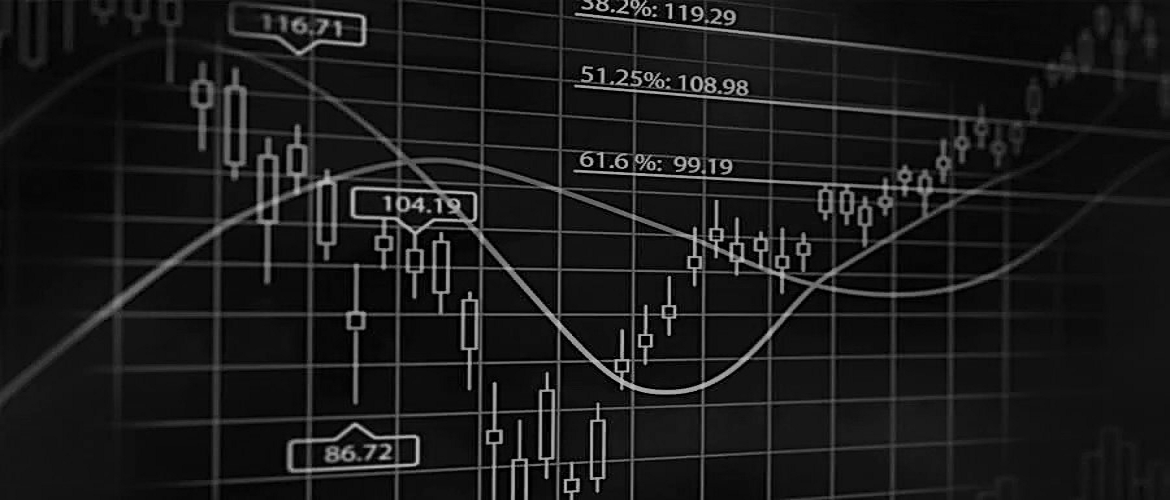
> The stock market refers to the collection of markets and exchanges where regular activities of buying, selling, and issuance of shares of publicly-held companies take place.
> A stock or share (also known as a company's "equity") is a financial instrument that represents ownership in a company or corporation and represents a proportionate claim on its assets (what it owns) and earnings (what it generates in profits).

Stock price forecasting is a widely studied topic in many fields, including trading, finance, statistics, and computer science. Stocks can be bought and sold at profitable positions by predicting the direction of future prices.

# Table of contents
1. [Installing necessary packages](#section-one)
1. [Collecting train data](#section-two)
1. [LSTM](#section-three)
1. [ARIMA](#section-four)
1. [Monte Carlo Markov Chain (Metropolis_Hastings method)](#section-five)
1. [Prediction optimization](#section-six)  
1. [Summary](#section-seven)    

<a id="section-one"></a>
# Installing necessary packages

For data scraping I use yfinance package, it is easy to install and use.

Yfinance is an open source library developed by Ran Aroussi for accessing Yahoo Finance's financial data. Yahoo Finance provides excellent market data on stocks, bonds, currencies, and cryptocurrencies. Also, it provides market news, reports, and analysis, as well as options and fundamentals data- setting it apart from some of its competitors.

Documentation is available at [Yfinance](https://pypi.org/project/yfinance/)

In [1]:
!pip install yfinance --quiet
!pip install pmdarima --quiet

Python package installer "pip" is used to install two libraries: "yfinance" and "pmdarima".


Installing the "yfinance" library is achieved with the first line "!pip install yfinance --quiet". Using this library, you can retrieve financial data from Yahoo! Finance. In order to suppress the output messages generated during installation, use the "--quiet" flag.


With the second line "!pip install pmdarima --quiet", the "pmdarima" library is installed. The AutoRegressive Integrated Moving Average (ARIMA) model is used in this library for time series analysis and forecasting. "--quiet" suppresses any output messages generated during installation.


This code installs two Python libraries that may be useful for financial analysis and time series forecasting.

*PuLP is a python library which can be used to solve linear programming problems.*

PuLP is usually used for simpler tasks, but it can also come handy for predictions blending. By default, CBC solver is used in the package, but there are plenty more of them available, for example, CPLEX, Gurobi and GLPK. For reference, you can see how PuLP is used for optimization tasks in my other notebook: [Optimization problem solving with PuLP](https://www.kaggle.com/equinxx/optimization-problem-solving-with-pulp)

[Documentation source](http://coin-or.github.io/pulp/)

In [2]:
!pip install statsmodels==0.11.0rc1 --quiet
!pip install -Iv pulp==1.6.8 --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.1.0 requires statsmodels<0.14,>=0.13.2, but you have statsmodels 0.11.0rc1 which is incompatible.
pmdarima 2.0.3 requires statsmodels>=0.13.2, but you have statsmodels 0.11.0rc1 which is incompatible.
  Using cached PuLP-1.6.8-py3-none-any.whl
  Using cached pyparsing-3.0.9-py3-none-any.whl (98 kB)
ERROR: Could not install packages due to an OSError: [Errno 13] Permission denied: '/opt/conda/lib/python3.7/site-packages/pyparsing/__init__.py'
Consider using the `--user` option or check the permissions.



Two specific versions of libraries are installed using the Python package installer "pip": "statsmodels" and "pulp".

"!pip install statsmodels==0.11.0rc1 --quiet" installs the "statsmodels" library version 0.11.0rc1. Statistical modeling and econometrics can be performed using this library in Python. As indicated by the "==0.11.0rc1" notation, the library version 0.11.0rc1 is a specific version of the library that may be required by some code or projects. During installation, the "--quiet" flag is used to suppress output messages.

It installs version 1.6.8 of the "pulp" library with the second line "!pip install -Iv pulp==1.6.8 --quiet". In Python, this library is used for linear programming optimization. If a newer version of the library is already installed, the "-Iv" option forces the installation of the specified version. Installing this specific version is ensured by the "==1.6.8" notation. During the installation process, "--quiet" suppresses any output messages generated.

By ensuring that these specific versions of libraries are installed, even if newer versions are available, this code installs two specific versions of libraries that may be required by certain code or projects.

<a id="section-two"></a>
# Collecting train data

In [3]:
import yfinance as yf

# getting data from Yahoo Finance
stock_name = 'AMD'  # here you can change the name of stock ticker, for example we will take AMD ticker
data = yf.download(stock_name, start="2020-03-26", end="2021-03-29")

[*********************100%***********************]  1 of 1 completed


This code imports the "yfinance" library with the alias "yf" and uses it to download historical stock price data from Yahoo Finance for a given stock ticker.

"import yfinance as yf" imports the "yfinance" library and creates an alias "yf". Financial data is retrieved from Yahoo Finance using this library.

The second line creates a variable "stock_name" with the value 'AMD', which represents the stock ticker of the company whose stock price data should be downloaded. A different stock can be downloaded by changing this value.

For the third line, we use the "download" function from the "yfinance" library to retrieve historical stock prices between the specified dates for the given stock ticker. A start date of March 26th, 2020 and an end date of March 29th, 2021 are used in this example. "data" stores the retrieved data.

Through the "yfinance" library in Python, this code retrieves historical stock prices from Yahoo Finance for a given ticker.

In [4]:
# import plotly package for graphs
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

This code imports several modules and functions from the plotly package, which is used to create interactive graphs and visualizations.

'# import plotly package for graphs' is a comment that describes what the following code is for.

Plotly, a popular Python library that creates interactive visualizations, is imported by the second line "import plotly".

"import plotly.graph_objs as go" imports the "graph_objs" module from the "plotly" package, and creates an alias "go". There are several classes in this module that define different types of graphs and visualizations, including scatter plots, bar charts, and heatmaps.

By importing "express" from the "plotly" package, and creating an alias "px" for it, the fourth line imports "express" from the "plotly" package. There are many types of visualizations that can be created with minimal coding using this module.

This fifth line imports the "make_subplots" function from the "plotly" package's "subplots" module. Within a single figure, this function creates a grid of subplots.

Overall, this code imports several key components of the "plotly" package that are commonly used in Python to create interactive graphs and visualizations.

<a id="section-three"></a>
# LSTM model

Model structure:


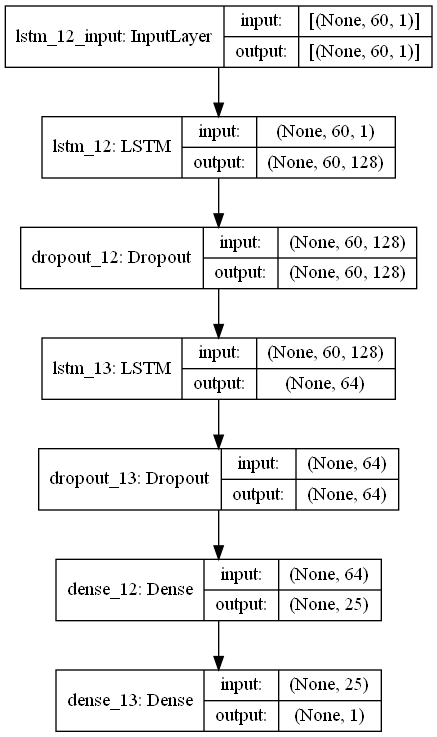

In [5]:
'''
To build and train a Long Short-Term Memory (LSTM) model for time series forecasting, the code imports several modules and functions. As part of the "sklearn.preprocessing" module, it imports the class "MinMaxScaler", which normalizes the input data for the LSTM model, as well as packages for visualization, deep learning, and model evaluation, including "math", "matplotlib.pyplot", "keras", "pandas", "numpy", "sklearn.metrics", "sklearn.model_selection", and "keras.callbacks". Additionally, it imports classes and functions for building LSTM models, such as "Sequential", "Dense", "LSTM", and "Dropout". A few lines are repeated unnecessarily, such as "Sequential" and "Dense, LSTM". This Python code provides a foundation for building and training an LSTM model for time series forecasting.
'''
from sklearn.preprocessing import MinMaxScaler
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, LSTM

def lstm(stock_name, data):
    """
  Using Yahoo Finance historical stock price data, the given code filters the data to only keep the 'Close' price of the stock. Using the "filter" method of the "data" variable, we create a new DataFrame containing only the 'Close' column. A NumPy array is then created from the filtered data using the "values" method and stored in the "dataset" variable.


 Following that, the "np.ceil" function is used to round up 80% of the length of the "dataset" array to the nearest integer. A variable named "training_data_len" stores this length.


 In summary, this code prepares historical stock price data for further processing by filtering the data to only include the 'Close' price of the stock and calculating the length of the training data, which will be used to train the LSTM model.
      """

    # Choose only Close price of stock
    data = data.filter(['Close'])
    dataset = data.values
    # Train data - 80%, test - 20%
    training_data_len = int(np.ceil( len(dataset) * .80 ))
    
    """
To prepare the historical stock price data for input into the LSTM model, the given code scales it between 0 and 1. Sklearn.preprocessing provides the "MinMaxScaler" class for this purpose. By specifying the "feature_range" parameter, a new instance of the "MinMaxScaler" class is created with a feature range of 0 to 1. The new instance is then stored in the "scaler" variable.

Next, the scaling transformation is applied to the "dataset" array using the "fit_transform" method of the "scaler" object. Scales the data to the desired range and stores it in the scaled_data variable as a NumPy array.

A common preprocessing step in deep learning models, like the LSTM, is to scale historical stock price data to a range between 0 and 1.
    """
    # Scale our data from 0 to 1
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(dataset)
    
    """
    By creating input sequences and output values, the given code prepares scaled historical stock price data for training the LSTM model. A new variable "train_data" is created containing the first 80% of the "scaled_data" array. For the LSTM model, this data will be used as training data.

To store the input sequences and output values for training, the code creates empty lists "x_train" and "y_train.". The input value is the 60 most recent stock prices, and the output value is the next stock price after 60 days.

Starting at index 60, the "train_data" array is iterated through using a for loop. In each iteration, 60 recent stock prices are added to "x_train" as an array, and the next stock price is added to "y_train". To ensure that the loop works correctly, the "if" statement within the loop prints out the first input sequence and output value.

The "x_train" and "y_train" lists are converted to NumPy arrays using the "np.array" function after the loop completes. Afterwards, the "x_train" array is reshaped into a 3D array with dimensions (number of input sequences, 60, 1), where "number of input sequences" is the number of input sequences created in the for loop.

To train the LSTM model on the scaled historical stock price data, this code creates the necessary input sequences and output values. NumPy arrays are created by storing 60-day input sequences and the corresponding next stock price output value.
    """
    # Use our scaled data for training
    train_data = scaled_data[0:int(training_data_len), :]
    x_train = []
    y_train = []

    for i in range(60, len(train_data)):
        x_train.append(train_data[i-60:i, 0])
        y_train.append(train_data[i, 0])
        if i<= 61:
            print(x_train)
            print(y_train)
            print()

    x_train, y_train = np.array(x_train), np.array(y_train)

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    
    
    """
Using the scaled historical stock price data as inputs and outputs, the given code constructs an LSTM model for time series forecasting. Using the "Sequential" class from the "keras.models" module, the model architecture is defined.

The first layer of the model is an LSTM layer with 128 units, which returns the full sequence of outputs instead of just the last output, and has an input shape of (60, 1), which corresponds to the input sequence shape. LSTM layers are followed by dropout layers that prevent overfitting and regularize the neural networks.

In the second layer, an LSTM is also used, but it has 64 units and returns only the last result. LSTM is followed by a dropout layer.

In the third layer, there are 25 units and an activation function based on ReLU. A single unit is used in the final, dense layer to predict the stock price.

Using the Adam optimizer and mean squared error loss function, the model is compiled after defining the model architecture. As part of the training process, accuracy is also measured.

Scaled historical stock price data is used to train the model using the input sequences and output values. "batch_size" is set to 1, meaning that the weights are updated after each input sequence. It will run through the entire training data 21 times if the "epochs" parameter is set to 21.

"Multi_input_and_output_model.png" is the result of plotting the model using the plot_model function from the "keras.utils" module.

In summary, this code creates, compiles, and trains an LSTM model that uses scaled historical stock price data as inputs and outputs. Two LSTM layers, two dropout layers, and two dense layers make up the model architecture. Models are trained using the Adam optimizer and the mean squared error loss function. Additionally, the model structure is visualized and saved as an image.
    """
    # Build LSTM model
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape = (x_train.shape[1], 1)))
    model.add(Dropout(0.35))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(25, activation = 'relu'))
    model.add(Dense(1))
    
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

    # Тrain the model
    model.fit(x_train, y_train, batch_size=1, epochs=21)
    
    # Structure of the model
    keras.utils.plot_model(model, 'multi_input_and_output_model.png', show_shapes=True)

    """
Using the given code, you can evaluate the performance of the trained LSTM model using a test dataset. The first step is to create a new variable "test_data" that contains the last 20% of the "scaled_data" array, starting 60 days before the end of the dataset. We will use this data to test the LSTM model.

To store the input sequences and actual output values of the test dataset, empty lists "x_test" and "y_test" are created by the code. In "y_test," the output values are taken directly from the original dataset array rather than the scaled data.

The "test_data" array is iterated through using a for loop starting at index 60. "X_test" contains a list of arrays representing the 60 most recent stock prices for each iteration.

A NumPy array is created from the "x_test" list using the "np.array" function after the loop completes. The "x_test" array is then reshaped into a 3D array with dimensions (number of input sequences, 60, 1), where "number of input sequences" refers to the number of input sequences created in the for loop.

To evaluate the performance of the trained LSTM model on the test dataset, this code creates the necessary input sequences and output values. To generate predicted stock prices, the model uses 60-day input sequences stored as a NumPy array. For comparison with the predicted values, the actual output values for the test dataset are also stored as a NumPy array.
    """
    # Create test dataset
    test_data = scaled_data[training_data_len - 60: , :]
    x_test = []
    y_test = dataset[training_data_len:, :]
    for i in range(60, len(test_data)):
        x_test.append(test_data[i-60:i, 0])

    x_test = np.array(x_test)

    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

    """
The given code generates predictions for the test dataset using the trained LSTM model and calculates the root mean squared error (RMSE) between the predicted and actual output values.

To predict stock prices for the "x_test" input sequences, the trained LSTM model uses the "predict" method. Inverse_transform of the "scaler" object converts these predicted prices back to the original scale from the range of 0 to 1.

By using the RMSE formula, which involves finding the square root of the squared differences between the predicted and actual stock prices from the "y_test" array, the RMSE can be calculated between the predicted and actual stock prices. A console is then displayed with the RMSE value.

This code generates predicted stock prices and compares them to actual stock prices in order to evaluate the performance of the trained LSTM model on the test dataset. Model performance is measured by the RMSE, which shows the difference between predicted and actual values.

    """
    # Predict on test data
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)

    # For finding error we use RMSE formula, but MSE can be used too
    rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
    print(f'RMSE LSTM: {rmse}')
    
    """
By extracting the corresponding "Close" prices from the "data" DataFrame and reshaping them into NumPy arrays, the given code prepares the training and validation data for visualization.

In the "data" DataFrame, the first 80% are selected to create the "train" variable, while the remaining 20% are selected to create the "valid" variable. Datasets for training and validation are stored in these variables.

Using the "np.reshape" function, each dataset is converted into a 1D array with length equal to the number of data points. A "reshape" function is called twice, once for the "train" dataset with length 203 and once for the "valid" dataset with length 50.

The "np.reshape" function is also used to reshape the predicted stock prices generated by the LSTM model into a 1D array with 50 elements. In the following code, we will use these arrays to visualize actual and predicted stock prices.

Using this code, the "Close" prices of the training, validation, and predicted stock prices are extracted and reshaped into 1D NumPy arrays for visualization.
    """
    # Graphs
    train = data[:training_data_len]
    valid = data[training_data_len:]
    #valid['Predictions'] = predictions
    train_gr = np.reshape(train, (203,))
    train_gr = train_gr['Close']
    valid_gr = np.reshape(valid, (50,))
    valid_gr = valid_gr['Close']
    preds_gr = np.reshape(predictions, (50,))
    

    """
To visualize the training, validation, and predicted stock prices generated by the LSTM model, the following code uses the plotly library.

Using the "list" and "range" functions, two lists "x_train" and "x_valid" are created to represent the training and validation data points, respectively. In the plot, the x-coordinates will be taken from these lists.

The "Figure" function from the "plotly.graph_objs" module is then used to create a new plot object. Using the "add_trace" method, three scatter plot traces are added to the plot object. Plotted against the corresponding "x_train" or "x_valid" lists, each trace corresponds to the "train_gr", "valid_gr", and "preds_gr" arrays, respectively.

In the "update_layout" method of the plot object, various parameters can be customized, including the plot background color, axis labels, legend position, and title. Using the plot object's "show" method, the resulting plot is displayed.

The code creates a plot of the LSTM model's training, validation, and predicted stock prices, indicating their timesteps on the x-axis and their stock prices on the y-axis. Plotly library is used to create the plot, which is customized with various parameters to enhance readability.
    """
    x_train = list(range(0, len(train_data)))
    x_valid = list(range(len(train_data)-1, len(dataset)))
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=x_train, y=train_gr, mode='lines+markers', marker=dict(size=4),  name='train', marker_color='#39304A'))
    fig.add_trace(go.Scatter(x=x_valid, y=valid_gr, mode='lines+markers', marker=dict(size=4), name='valid', marker_color='#A98D75'))
    fig.add_trace(go.Scatter(x=x_valid, y=preds_gr, mode='lines+markers', marker=dict(size=4), name='predictions', marker_color='#FFAA00'))
    fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  plot_bgcolor='#FFFFFF',  
                  xaxis=dict(gridcolor = 'lightgrey'),
                  yaxis=dict(gridcolor = 'lightgrey'),    
                  title_text = f'{stock_name} LSTM data', title_x = 0.5,
                  xaxis_title="Timestep",
                  yaxis_title="Stock price",
                  margin=dict(l=0, r=0, t=30, b=0))
    fig.show()
    
    """
The given code uses the trained LSTM model to predict stock prices for the following month.

"Yfinance" library's "yf.download" function is used to download new stock price data for April. The resulting DataFrame is converted into a NumPy array by filtering out all but the "Close" prices.

Scaled data is then used to generate input sequences for the LSTM model using the "MinMaxScaler" object created earlier. The sequences are created using a sliding window of length 20 over the scaled data.

Using the "predict" method of the trained model, the resulting sequences are reshaped to the required input shape of the LSTM model. By using the "inverse_transform" method of the "scaler" object, these predicted prices are converted back to their original scale.

To convert historical stock prices into NumPy arrays, the "yf.download" function was used to download data for the month of April, then filtered to include only "Close" prices. The predicted stock prices are then appended to the historical data array, and the resulting array is stored in "pred_lstm".

This code creates a complete time series of predicted stock prices for a given stock ticker by combining predictions from the trained LSTM model with historical stock price data.
    """
    # Predict stock prices for next moth
    data_new = yf.download(stock_name, start="2021-03-01", end="2021-04-30")

    data_new = data_new.filter(['Close'])
    dataset = data_new.values
    training_data_len = len(dataset)

    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(dataset)

    test_data = scaled_data[training_data_len - len(data_new): , :]
    x_test = []
    y_test = dataset[training_data_len:, :]
    for i in range(20, len(test_data)):
        x_test.append(test_data[i-20:i, 0])

    x_test = np.array(x_test)

    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

    hist_data_new = yf.download(stock_name, start="2021-04-01", end="2021-05-04")
    hist_data_new = hist_data_new.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)
    hist_data_new = hist_data_new['Close']
    hist_data_new = np.array(hist_data_new)
    pred_lstm = model.predict(x_test)
    pred_lstm = pred_lstm[:-1]
    pred_lstm = scaler.inverse_transform(pred_lstm)

    
    """
Based on the predicted stock prices for the next month, as well as the historical stock prices for April, this code generates a plot.

As there are 22 business days in April 2021, the predicted stock prices generated in the previous code block are reshaped into a one-dimensional array.

From the "plotly.graph_objs" module, the "go.Figure()" function is used to create a new plot. The "add_trace()" method of the plot object is used to add two scatter plot traces to the plot. For each business day in April, the first trace shows historical stock prices, while the second trace shows predicted stock prices.

A plot object's attributes are then used to customize the plot layout. Using the "update_layout()" method, the plot title, axis titles, and legend are set, while the "xaxis" and "yaxis" attributes set the plot background and grid lines.

By using the "show()" method of the plot object, the plot is displayed. Plotly's library is used to plot the predicted stock prices for the month of April overlaid on historical stock prices from April.
    """
    # build graphs
    preds_gr = np.reshape(pred_lstm, (22,))
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=list(range(0, 21)), y=hist_data_new, mode='lines+markers',  name='historical', marker_color='#39304A'))
    fig.add_trace(go.Scatter(x=list(range(0, 21)), y=preds_gr, mode='lines+markers', name='predictions', marker_color='#FFAA00'))
    fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  plot_bgcolor='#FFFFFF',  
                  xaxis=dict(gridcolor = 'lightgrey'),
                  yaxis=dict(gridcolor = 'lightgrey'),    
                  title_text = f'{stock_name} LSTM prediction', title_x = 0.5,
                  xaxis_title="Timestep",
                  yaxis_title="Stock price",
                  margin=dict(l=0, r=0, t=30, b=0))
    fig.show()
    
    return pred_lstm, rmse

In [6]:
lstm_pred, lstm_rmse = lstm(stock_name, data)

[array([0.08982803, 0.07299674, 0.09641421, 0.05287229, 0.01957555,
       0.03476036, 0.        , 0.09019393, 0.09092575, 0.11342848,
       0.10592757, 0.1527625 , 0.22575924, 0.22685696, 0.26271498,
       0.25631172, 0.26308088, 0.18898643, 0.24387117, 0.24350533,
       0.24862788, 0.25429933, 0.23637026, 0.20252469, 0.17929014,
       0.13336994, 0.18240032, 0.17563115, 0.17508232, 0.17124041,
       0.19392606, 0.24057815, 0.20435416, 0.17544823, 0.21807534,
       0.21240396, 0.21953897, 0.23563851, 0.2524698 , 0.22063669,
       0.23014998, 0.19392606, 0.18569341, 0.16739849, 0.20508597,
       0.20197587, 0.20032932, 0.18551042, 0.18368095, 0.19227952,
       0.18990123, 0.2524698 , 0.27167945, 0.18733995, 0.19959751,
       0.22118551, 0.21716061, 0.21880716, 0.20947678, 0.21295279])]
[0.22264907067176842]

[array([0.08982803, 0.07299674, 0.09641421, 0.05287229, 0.01957555,
       0.03476036, 0.        , 0.09019393, 0.09092575, 0.11342848,
       0.10592757, 0.1527625 , 0.22

2023-04-27 12:26:39.700477: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-04-27 12:26:39.700568: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-27 12:26:39.700602: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (book1): /proc/driver/nvidia/version does not exist
2023-04-27 12:26:39.723146: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/21
143/143 [==============================] - 9s 37ms/step - loss: 0.0565 - accuracy: 0.0070
Epoch 2/21
143/143 [==============================] - 5s 38ms/step - loss: 0.0216 - accuracy: 0.0070
Epoch 3/21
143/143 [==============================] - 5s 38ms/step - loss: 0.0185 - accuracy: 0.0070
Epoch 4/21
143/143 [==============================] - 6s 41ms/step - loss: 0.0161 - accuracy: 0.0070
Epoch 5/21
143/143 [==============================] - 6s 39ms/step - loss: 0.0161 - accuracy: 0.0070
Epoch 6/21
143/143 [==============================] - 6s 40ms/step - loss: 0.0132 - accuracy: 0.0070
Epoch 7/21
143/143 [==============================] - 6s 42ms/step - loss: 0.0134 - accuracy: 0.0070
Epoch 8/21
143/143 [==============================] - 6s 40ms/step - loss: 0.0109 - accuracy: 0.0070
Epoch 9/21
143/143 [==============================] - 6s 40ms/step - loss: 0.0109 - accuracy: 0.0070
Epoch 10/21
143/143 [==============================] - 6s 40ms/step - loss: 0.0133 - accura

AttributeError: module 'keras.utils' has no attribute 'plot_model'

It appears that the code calls a function called lstm with two arguments: stock_name and data.

LSM_pred and LSM_rmse are then assigned the return values of the function.

In order to predict future stock prices, the LSTM function likely takes in some stock data for a particular stock (stock_name) and uses a long short-term memory (LSTM) model. As a result, the lstm_pred variable would contain the predicted stock prices, while lstm_rmse would contain the root mean square error (RMSE) of the predictions.

It is impossible to provide a more detailed explanation of the lstm function without seeing the implementation.

In [ ]:
# Check size of predictions array
print(lstm_pred.shape)

By calling the shape attribute on the lstm_pred array, the code checks its shape and prints the result.

Numpy arrays (which lstm_pred is likely to be) have a shape attribute that returns a tuple of their dimensions. As a result of lstm_pred.shape, a tuple containing two elements representing row and column numbers will be returned.

Debugging and understanding how data is processed can be enhanced by printing the shape of an array. As an example, knowing the shape of the lstm_pred array can help ensure that a subsequent calculation is done correctly and that the inputs match the expected values.

<a id="section-four"></a>
# ARIMA

The Autoregressive Integrated Moving Average (ARIMA) Model converts non-stationary data into stationary data before analyzing it. It is one of the most popular models for predicting linear time series data.

Known for its robustness, efficiency, and ability to predict short-term share prices, the ARIMA model is extensively used in finance and economics.

Let's perform ADF test for stock data:

In [ ]:
data_adf = data.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)
data_adf = data_adf['Close']

from pmdarima.arima import ADFTest
adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(data_adf)

According to the code, the augmented Dickey-Fuller (ADF) test is being used to test for stationarity in time series data.

The code first drops several columns from the data DataFrame using the drop() function with axis=1. A new DataFrame called data_adf is created, which consists only of the 'Close' column from the original data frame.

An instance of the ADFTest class is created with an alpha value of 0.05, representing the significance level of the test, from the pmdarima library.

Lastly, the data_adf DataFrame is passed to the should_diff() method of the ADFTest object. The ADF test is performed on the input data and returns True if the data needs to be differenced to achieve stationarity, and False otherwise.

The code checks whether the 'Close' column of the data DataFrame is stationary or not using the ADF test. With the 'Close' column data as input, the should_diff() method of the ADFTest class is called. To make the data stationary, differencing may be required if True is returned.

As a result, we can use regressive models for forecasting since the data is stationary. We can now apply ARIMA (Auto ARIMA)

In [ ]:
"""
Data analysis, visualization, and time series analysis are commonly performed with Python libraries imported into this code. A number of libraries are imported with their respective aliases, including OS, warnings, numpy, pandas, matplotlib, pmdarima, and random. As well as defining the figure size and style, it also sets some configuration parameters for plotting. To load the wine industry time series dataset, the load_wineind() function is imported from pmdarima.datasets. In addition, the code imports the ARIMA class from statsmodels.tsa.arima_model, which is used to fit an ARIMA model to time series data, and the ADFTest class from pmdarima.arima, which performs the augmented Dickey-Fuller (ADF) stationarity test. The warnings module suppresses warning messages generated by the program, and the random module generates random numbers.
"""
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pmdarima as pm
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import ADFTest
from pmdarima.datasets import load_wineind
import random

def arima(stock_name, data):
    """
    The purpose of this code is to prepare the stock data for a time series analysis. A new variable df_close is created as a result of selecting the 'Close' column of the data DataFrame. A new variable df_log is created from the df_close series. In the next step, the code divides the data into train and test sets based on a 90-10 ratio. Specifically, 90% of the df_log series are assigned to the train_data variable, while 10% are assigned to the test_data variable. By taking 1% of the total length of the df_log series and adding 1, the code calculates how many values should be in the test set. To index the train_data and test_data series, the code creates two new lists, x_train and x_test. Specifically, x_train contains the integers from 0 to 223 and x_test contains the integers from 224 to the length of the data frame.
    """
    df_close = data['Close']
    
    # Split data into train and test set (90% - train, 10% - test)
    df_log = df_close
    #train_data, test_data = df_log[3:int(len(df_log) * 0.9)], df_log[int(len(df_log) * 0.9):]
    train_data, test_data = df_log[3:int(len(df_log) * 0.9)], df_log[int(len(df_log) * 0.9):]
    test_values = len(df_log) * 0.01 + 1.0
    x_train = list(range(0, 224))
    x_test = list(range(224, int(len(data))))
    
    """
    Using the Plotly library, this code creates a line chart of train and test data for a given stock. The first step is to create a new Figure object and assign it to the fig variable. By using the add_trace() method, we add two traces to the figure. A train_data series is shown on the first trace, and a test_data series is shown on the second trace. Traces are plotted as lines and markers, and markers are colored with the marker_color attribute. The update_layout() method is used to customize the layout of the figure, including the legend orientation, the plot background color, the grid color of the x and y axes, and the title. The show() method displays the figure in the notebook or in a new browser window, depending on how the Plotly library is configured. For a given stock, the code creates a line chart that can be used to visualize the performance of a time series forecasting model.
    """
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=x_train, y=train_data, mode='lines+markers', marker=dict(size=4),  name='train', marker_color='#39304A'))
    fig.add_trace(go.Scatter(x=x_test, y=test_data, mode='lines+markers', marker=dict(size=4), name='test', marker_color='#A98D75'))
    fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  plot_bgcolor='#FFFFFF',  
                  xaxis=dict(gridcolor = 'lightgrey'),
                  yaxis=dict(gridcolor = 'lightgrey'),
                  title_text = f'{stock_name} ARIMA data', title_x = 0.5,
                  xaxis_title="Timestep",
                  yaxis_title="Stock price",
                  margin=dict(l=0, r=0, t=30, b=0))
    fig.show()
    
    """
    With the help of the auto_arima() function from the pmdarima library, the time series data contained in the df_log variable is fitted to an ARIMA model. It searches over different combinations of hyperparameters to find the best model fit using the auto_arima() function. In addition to the start values of p, d, and q, the maximum values of p, d, and q, the seasonal period m, and other options, including whether to use a stepwise approach and how many model fits to perform, the function takes several arguments. By using the summary() method, the function returns an ARIMA model object that can be used to print a summary of the model. It includes information such as the order of the model, the coefficients, the standard error of the coefficients, and the information criterion values, which can be used to evaluate the model's performance. This code generates a summary of the model fit to the time series data and performs automated ARIMA modeling.
    """
    model =  pm.auto_arima(df_log,start_p=0, d=None, start_q=0, 
                          max_p=5, max_d=5, max_q=5, start_P=0, 
                          D=1, start_Q=0, max_P=5, max_D=5,
                          max_Q=5, m=7, seasonal=True, 
                          error_action='warn',trace = True,
                          supress_warnings=True,stepwise = True,
                          random_state=20,n_fits = 50 )

    model.summary()

    """
    Based on the df_log time series data, this code generates predictions using the ARIMA model and evaluates its performance using the root mean squared error (RMSE). First, the Volume column of the DataFrame is selected and assigned to a new variable, exo_data. After that, the last 10% of the exo_data series is assigned to the exo_data variable once again, which is used as exogenous variable data. In this case, the predict() method of the model object is called with the n_periods argument set to 22 and the X argument set to the exo_data series. The ARIMA model generates 22 predictions for the next 22 time periods, using the exo_data series as the exogenous variables. Using the np.vstack() function, the predicted values are assigned to the preds variable. With a start date of 2021-04-01 and an end date of 2021-05-04, the historical data for the stock is downloaded using the Yahoo Finance API. Several columns of the hist_data DataFrame are then removed, leaving only the 'Close' column. In order to assign the 'Close' column to the hist_data variable, the column is converted into a numpy array. A final calculation is made based on predicted and historical values, and the RMSE is printed out. A RMSE estimate is used to evaluate the performance of the ARIMA model with exogenous variables.
    """
    exo_data = data['Volume']
    exo_data = exo_data[int(len(exo_data) * 0.9):]
    
    preds = model.predict(n_periods = 22, X = exo_data)

    preds = np.vstack(preds)
    hist_data = yf.download(stock_name, start="2021-04-01", end="2021-05-04")
    hist_data = hist_data.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)
    hist_data = hist_data['Close']
    hist_data = np.array(hist_data)
    
    rmse = np.sqrt(np.mean(((preds - hist_data) ** 2)))
    print(f'RMSE ARIMA: {rmse}')
    
    # build graphs
    """
    Plotly is used to create a line chart showing the historical and predicted stock prices for a given stock. Using the np.reshape() function, the preds variable containing the predicted values is reshaped into a one-dimensional array and assigned to preds_gr. Afterward, the fig variable is assigned a new Figure object. The add_trace() method is used to add two traces to the figure. First, there is the historical data for the stock, and then there is the predicted data for the stock. Traces are plotted as lines and markers, and markers are colored using the marker_color attribute. Next, the update_layout() method is used to customize the layout of the figure, including the legend orientation, the plot background color, the grid color of the x and y axes, and the title. Based on the configuration of the Plotly library, the show() method displays the figure in the notebook or in a new browser window. This code creates a line chart of historical and predicted stock prices for a given stock, which can be used to visualize ARIMA's performance.
    """
    preds_gr = np.reshape(preds, (22,))
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=list(range(0, 21)), y=hist_data, mode='lines+markers',  name='historical', marker_color='#39304A'))
    fig.add_trace(go.Scatter(x=list(range(0, 21)), y=preds_gr, mode='lines+markers', name='predictions', marker_color='#FFAA00'))
    fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  plot_bgcolor='#FFFFFF',  
                  xaxis=dict(gridcolor = 'lightgrey'),
                  yaxis=dict(gridcolor = 'lightgrey'),
                  title_text = f'{stock_name} ARIMA prediction', title_x = 0.5,
                  xaxis_title="Timestep",
                  yaxis_title="Stock price",
                  margin=dict(l=0, r=0, t=30, b=0))
    fig.show()

    return preds, rmse

In [ ]:
arima_pred, arima_rmse = arima(stock_name, data)
print(arima_pred.shape)

The code calls the arima() function to generate predictions for a given stock, then prints the shape of the arima_pred variable. It takes two arguments: the stock_name, which is a string representing the name of the stock, and the data, which is a Pandas DataFrame containing historical stock prices. Using the auto_arima() function from the PMdarima library, the arima() function fits the data into an ARIMA model, generates predictions for the next 22 time periods using the predict() method of the model object, and calculates the root mean squared error (RMSE) of the predictions using the functions np.sqrt() and np.mean(). This function returns two values: the arima_pred variable, which is a numpy array with the predicted values, and the arima_rmse variable, which is a float representing the RMSE. Print() is then used to print the shape of the arima_pred variable to the console, which is the number of predicted values generated by the ARIMA model. In summary, this code generates predictions for a given stock using an ARIMA model and prints the number of predicted values.

In light of the large difference between real and predicted data, we may want to try other regressive methods, such as SARIMAX or VAR. I tested them, but the results were almost the same (see below). There might be a high level of market volatility during the prediction period, which makes such methods incapable of adjusting their forecasting trend for each day. By the way, older data is less likely to produce errors if we apply these regressive methods to it.

**SARIMAX**

In [ ]:
"""
A time series data set is split into train and test sets by importing the SARIMAX class from the statsmodels.tsa.statespace.sarimax module. A seasonal ARIMA (SARIMA) model is fitted to time series data by importing the SARIMAX class. Second, the 'Close' column of the data DataFrame is selected and assigned to a new variable data3. A 90-10 ratio is then used to split the data into train and test sets. Data3 series is divided into train3_data and test3_data variables, with the first 90% of each assigned to train3_data. In the next step, two new lists are created, x_train and x_test, which are used to index train3_data and test3_data, respectively. The data3 DataFrame contains the integers from 0 to 223 in x_train, and the integers from 224 to its total length in x_test. By splitting the stock data into train and test sets, this code prepares stock data for SARIMA modeling.
"""
from statsmodels.tsa.statespace.sarimax import SARIMAX
data3 = data['Close']
    
# Split data into train and test set (90% - train, 10% - test)
train3_data, test3_data = data3[3:int(len(data3) * 0.9)], data3[int(len(data3) * 0.9):]
#test_values = len(data3) * 0.01 + 1.0
x_train = list(range(0, 224))
x_test = list(range(224, int(len(data3))))

"""
Data is prepared for SARIMAX modeling using this code, and a line chart is generated using Plotly. The first step is to select the 'Volume' column from the data dataframe and assign it to the variable exo_data. A final 10% of the exo_data series is then assigned to the exo_data variable, which is used as exogenous data for the SARIMAX model. As soon as the new Figure object is created, it is assigned to the fig variable. The method add_trace() is used to add two traces to the figure. Training data for a stock is represented by the first trace, and test data is represented by the second trace. A marker_color attribute sets the color of the markers for both traces, which are plotted as lines and markers. To customize the layout of the figure, the update_layout() method is used, which includes the legend orientation, the plot background color, the x and y axis grid color, the title, and the margin. The show() method displays the figure, depending on the Plotly library's configuration, in the notebook or in a new browser window. Using Plotly, this code prepares training and test data for SARIMAX modeling.
"""
exo_data = data['Volume']
exo_data = exo_data[int(len(exo_data) * 0.9):]

fig = go.Figure()
fig.add_trace(go.Scatter(x=x_train, y=train3_data, mode='lines+markers', marker=dict(size=4),  name='train', marker_color='#39304A'))
fig.add_trace(go.Scatter(x=x_test, y=test3_data, mode='lines+markers', marker=dict(size=4), name='test', marker_color='#A98D75'))
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  plot_bgcolor='#FFFFFF',  
                  xaxis=dict(gridcolor = 'lightgrey'),
                  yaxis=dict(gridcolor = 'lightgrey'),
                  title_text = f'{stock_name} SARIMAX data', title_x = 0.5,
                  xaxis_title="Timestep",
                  yaxis_title="Stock price",
                  margin=dict(l=0, r=0, t=30, b=0))
fig.show()
    
"""
Using the training data, this code fits a SARIMAX model, generates predictions for the test data, and calculates the root mean squared error (RMSE). The SARIMAX function from the statsmodels.tsa.statespace.sarimax module is used to create a SARIMAX model with order (3, 1, 2). The order parameter specifies the (p,d,q) parameters of the model, which determine the number of autoregressive, differencing, and moving average terms. In order to fit the model to the training data, the fit() method of the model object is called with the exogenous variable data as X argument. To suppress the convergence message, set disp to -1. To display summary statistics for the fitted model, the summary() method of the arima_model object is called. Using the predict() method of the arima_model object, predictions for the next 22 time periods are generated with a 95% confidence level. Predicted values are reshaped into a vertical numpy array using np.vstack() and assigned to preds3. Once again, the last 22 values of preds3 are assigned to preds3. Using the yf.download() function, historical stock data is downloaded from Yahoo Finance, and the 'Close' column is selected and assigned to the hist_data variable. By using the np.sqrt() and np.mean() functions, we calculate the RMSE between the predicted and actual stock prices. As a result of this code, SARIMAX predictions are generated for the training data and RMSE is calculated for the test data.
"""
model = SARIMAX(train3_data, order=(3, 1, 2))

arima_model = model.fit(X = exo_data, disp=-1)

print(arima_model.summary())


preds3 = arima_model.predict(n_periods=22, alpha=0.05)

preds3 = np.vstack(preds3)
preds3 = preds3[-22:]
hist_data = yf.download(stock_name, start="2021-04-01", end="2021-05-04")
hist_data = hist_data.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)
hist_data = hist_data['Close']
hist_data = np.array(hist_data)
    
rmse = np.sqrt(np.mean(((preds3 - hist_data) ** 2)))
print(f'RMSE SARIMAX: {rmse}')
    
"""
Using Plotly, this code displays the predicted and actual stock prices on a line chart. In the first step, the preds3 array is transformed into a 1-dimensional numpy array using np.reshape(). Secondly, the fig variable is assigned a new Figure object. This figure is enhanced by adding two traces using the add_trace() method. Historical stock prices are represented by the first trace, and predicted stock prices are represented by the second trace. Lines and markers are plotted for both traces, and the marker_color attribute is used to set their colors. Since each series contains 21 data points, we use the list(range(0, 21)) function to generate the x-axis values. The update_layout() method is used to customize the figure layout, including the legend orientation, the plot background color, the grid color of the x and y axes, the title, and the margin. The show() method displays the figure in the notebook or in a new browser window, depending on the configuration of the Plotly library. Using Plotly, this code creates a line chart that displays predicted and actual stock prices.
"""
preds_gr = np.reshape(preds3, (22,))
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(0, 21)), y=hist_data, mode='lines+markers', name='historical', marker_color='#39304A'))
fig.add_trace(go.Scatter(x=list(range(0, 21)), y=preds_gr, mode='lines+markers', name='predictions', marker_color='#FFAA00'))
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  plot_bgcolor='#FFFFFF',  
                  xaxis=dict(gridcolor = 'lightgrey'),
                  yaxis=dict(gridcolor = 'lightgrey'),
                  title_text = f'{stock_name} SARIMAX prediction', title_x = 0.5,
                  xaxis_title="Timestep",
                  yaxis_title="Stock price",
                  margin=dict(l=0, r=0, t=30, b=0))
fig.show()

**VAR**

In [ ]:
"""
Data is downloaded from Yahoo Finance and prepared for training and validation sets using this code. Firstly, the stock data for a particular stock specified by the stock_name variable is downloaded using the yf.download() function. The second step is to create a list of columns that include the stock's open, high, low, close, and volume data. Using the drop() method, the 'Adj Close' column is removed from the data4 DataFrame. The training set consists of the first 80% of stock data, while the validation set consists of the remaining 20%. To round down the indices, use the int() function. Validation data are assigned to the valid4 DataFrame, whereas training data are assigned to the train4 DataFrame. Data is downloaded from Yahoo Finance and prepared for training and validation by this code.
"""
import math
data4 = yf.download(stock_name, start="2020-03-26", end="2021-03-29")
cols = ['Open', 'High', 'Low', 'Close', 'Volume']
data4 = data4.drop(['Adj Close'], axis=1)

# Train set - 80%
train4 = data4[:int(0.8*(len(data)))]
valid4 = data4[int(0.8*(len(data))):]


"""
In this code, a Vector Autoregression (VAR) model is trained on the training set and predictions are made on the validation set. As a first step, the VAR() function is used to create a VAR model object with the training data train4 as the endogenous variables. The second step is to fit the VAR model to the training data using the fit() method on the model object. A constant trend in the model is specified by the trend parameter = 'ctt'. To generate predictions for the validation set, the forecast() method is called on the fitted model object with the number of steps equal to the length of the validation set. To generate a forecast, the forecast() method uses the training data as input to the VAR model. In the cols list, the column names match those in the pred4 DataFrame. The root mean square error (RMSE) is calculated for the 'Close' column of the predictions and the validation set using the math.sqrt() and mean_squared_error() functions from the math and sklearn.metrics libraries. VAR models are evaluated by printing their RMSE on the console. This code trains a VAR model on the training set, makes predictions on the validation set, and computes the RMSE.
"""
#fit the model
from statsmodels.tsa.vector_ar.var_model import VAR

model4 = VAR(endog=train4)
model4_fit = model4.fit(trend = 'ctt')

# make prediction on validation
prediction = model4_fit.forecast(model4_fit.y, steps=len(valid4))
pred4 = pd.DataFrame(index=range(0,len(prediction)),columns=[cols])
for j in range(0,5):
    for i in range(0, len(prediction)):
        pred4.iloc[i][j] = prediction[i][j]

# Check rmse
i = 'Close'
print('rmse value for', i, 'is : ', math.sqrt(mean_squared_error(pred4[i], valid4[i])))


"""
In this code, a VAR model is fitted to the entire data4 DataFrame and predictions for the next 23 days are made. Data4 serves as the endogenous variable in a VAR model created with the VAR() function. A VAR model is fitted to the data by calling the fit() method on the model object. A constant trend is specified by the trend parameter = 'ct'. To generate predictions for the next 23 days, the forecast() method is applied to the fitted model object. A numpy array called yhat is used to store the predictions. The fourth step is to extract the predictions for the 'Close' column and store them in a list called predictions. Iterating over the rows of the yhat numpy array, the loop extracts the 'Close' column prediction at index 3, which corresponds to the 'Close' column of the data4 DataFrame. To download historical stock data for a particular stock from April 1, 2021 to May 4, 2021, the yf.download() function is used. Hist_data DataFrame columns 'Open', 'High', 'Low', 'Adj Close', and 'Volume' are dropped using the drop() method. In a numpy array named hist_data, the 'Close' column is extracted and stored. This code uses a VAR model to make predictions for the next 23 days and downloads historical stock data to evaluate the results.
"""
model4 = VAR(endog=data4)
model4_fit = model4.fit(trend = 'ct')
yhat = model4_fit.forecast(model4_fit.y, steps=23)
preds = []

i = 0
while i < (len(yhat)):
    pr = yhat[i][3]
    preds.append([pr])
    i = i + 1
#print(preds)
hist_data = yf.download(stock_name, start="2021-04-01", end="2021-05-04")
hist_data = hist_data.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)
hist_data = hist_data['Close']
hist_data = np.array(hist_data)

"""
In this code, the preds list is reshaped from a 23x1 array to a 23-length 1D array called preds_gr using the np.reshape() function. The next step is to create a go.Figure() object called fig. The add_trace() method is used to add two scatter traces to the figure: one trace for the historical stock prices and one for the predicted stock prices. Lines and markers will be displayed for both traces when mode='lines+markers' is specified. A trace's name will appear in the legend if it has a name parameter. Trace markers are colored according to the marker_color parameter. Data are plotted on the x- and y-axes, respectively, based on the x and y parameters of each trace. A figure's layout is updated using the update_layout() method. For customizing the appearance of the figure, parameters such as legend_orientation, legend, plot_bgcolor, xaxis, yaxis, title_text, title_x, xaxis_title, yaxis_title, and margin are specified. Displaying the figure is completed by calling show(). Using the Plotly library, this code creates a plot of historical and predicted stock prices.
"""
preds_gr = np.reshape(preds, (23,))
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(0, 21)), y=hist_data, mode='lines+markers',  name='historical', marker_color='#39304A'))
fig.add_trace(go.Scatter(x=list(range(0, 21)), y=preds_gr, mode='lines+markers', name='predictions', marker_color='#FFAA00'))
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  plot_bgcolor='#FFFFFF',  
                  xaxis=dict(gridcolor = 'lightgrey'),
                  yaxis=dict(gridcolor = 'lightgrey'),
                  title_text = f'{stock_name} VAR prediction', title_x = 0.5,
                  xaxis_title="Timestep",
                  yaxis_title="Stock price",
                  margin=dict(l=0, r=0, t=30, b=0))
fig.show()

<a id="section-five"></a>
# Monte Carlo Markov Chain (Metropolings-Hastings method)

With MCMC, we can draw samples from any distribution that cannot be sampled directly. The posterior distribution of parameters can be sampled using it. There have been many successful applications of it, including computing the distribution of parameters given observations and some prior beliefs, as well as computing high-dimensional integrals in physics.


A number of multidimensional probability distributions p(x) must be sampled when applying Monte Carlo method. MKML methods are based on this solution. A number of attempts have been made to integrate very complex functions with random simulations. These attempts led to the Metropolis-Hastings algorithm.

In the algorithm, a simple distribution is used to extract suitable values from the posterior distribution P(Θ=θ/D).

By using Q to walk randomly in the distribution space, Metropolis-Hastings accepts or rejects new positions based on how likely the sample is. The "Markov Chain" part of MCMC is this "memoryless" random walk.


The function f determines the probability of each new sample. From the given distribution, f must be proportional. For expressing this proportionality, the function f is usually chosen. To get a new position of the parameter, just take our current one θ and propose a new one θ', that is randomly drawn from our distibution Q(θ'/θ). In general, it is a symmetric distribution, such as a normal distribution with a mean θ and some standard deviation σ: Q(θ'/θ) = N(θ,σ). The acception criterion for the sample θ' is the formula:

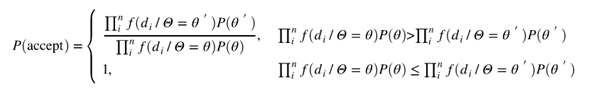

If θ' is more likely than the current θ, then we always accept θ'. If it is less likely than the current θ, then we might accept it or reject it randomly with decreasing probability, the less likely it is.

References: 
[Reference 1](https://github.com/Joseph94m/MCMC/blob/master/MCMC.ipynb)
[Reference 2](http://janroman.dhis.org/stud/I2010/MCBS/AFI.pdf)

For stock predicting using the following method we use stock price formula below, according to Black-Scholes method. That means, that price of stock follows a geometric Brownian motion with constant drift and volatility.

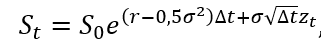

z_t is our random shift indicator, which is generated with MCMC method.
The inputs for the Black-Scholes equation are volatility (in our case 25%), stock price for previous time period and the risk-free interest rate (10%). As we predict prices for each day of next trading month, we use ∆t as 1(day)/22(trading days in month).


In [ ]:
"""
Numpy, math, matplotlib.pyplot, pandas, yfinance, statistics, scipy.special, scipy.stats, random, and sklearn.metrics are all imported by this code. These modules are loaded into memory using the import statement, allowing their functionality to be used.

Python's numpy library allows you to compute numerically. In Python, there is a built-in library for mathematical operations called math. In Python, matplotlib.pyplot provides plotting functionality. Pandas is a data manipulation and analysis library. The yfinance library downloads financial data from Yahoo Finance. Python's statistics library provides statistical computations. There is a large collection of special functions in mathematics in the scipy.special library. scipy.stats contains a wide range of statistical functions and probability distributions. Pseudo-random numbers are generated using Python's random library. The sklearn.metrics library allows you to evaluate the performance of machine learning models.

Sklearn.metrics includes a mean_squared_error function that can be used to calculate the mean squared error between two arrays.
"""
import numpy as np
import math
from numpy import linalg as la
import matplotlib.pyplot as plt
import math
import pandas as pd
import yfinance as yf
import statistics as stat
from scipy.special import ndtri
from scipy.stats import norm
import random
from sklearn.metrics import mean_squared_error

"""
In this code, mu, sig, and N are set to 1.1, 1, and 100000, respectively. In a normal distribution, mu represents the mean, sig represents the standard deviation, and N represents the number of samples.

We will use the variable pts to store the values generated by sampling the normal distribution with mu and sig parameters.
"""
mu, sig, N = 1.1, 1, 100000
pts = []


"""
q(x) is a function defined in this code. It calculates the probability density of a normal distribution with a mean mu and a standard deviation sig at a point x given an input parameter x.

The formula used to calculate this probability density is (1 / (math.sqrt(2 * math.pi * sig ** 2))) * (math.e ** (-((x - mu) ** 2) / (2 * sig ** 2))), which corresponds to the probability density function of a normal distribution. A Gaussian function is commonly known as this formula.
"""
def q(x):
    return (1 / (math.sqrt(2 * math.pi * sig ** 2))) * (math.e ** (-((x - mu) ** 2) / (2 * sig ** 2)))

"""
With MCMC(n), you can generate random samples from a probability distribution with a mean mu and a standard deviation sig using the Metropolis-Hastings algorithm. A proposal distribution q(x) is used, which is a normal distribution centered at the current sample with a fixed standard deviation. By using an acceptance-rejection mechanism, the algorithm generates n samples from an initial sample r. Proposed samples are always accepted if they are more probable than the current sample. It is accepted with a probability equal to the ratio of the proposal probabilities if it is less probable. A numpy array is returned as the result of the function.
"""
def MCMC(n):
    r = np.zeros(1)
    p = q(r[0])
    pts = []

    for i in range(N):
        rn = r + np.random.uniform(-1, 1)
        pn = q(rn[0])
        if pn >= p:
            p = pn
            r = rn
        else:
            u = np.random.rand()
            if u < pn / p:
                p = pn
                r = rn
        pts.append(r)

    pts = random.sample(pts, len(pts))
    pts = np.array(pts)
    
    return pts

def MH(stock_name, data):
    """
    Using the yfinance library, the code appears to download historical stock prices. Afterward, it removes columns that aren't needed for the analysis, leaving only the 'Close' price column. Numpy is used to convert the 'Close' price data.

The code then sets up variables such as maturity, volatility, risk-free rate, and time steps for a Monte Carlo simulation. The script also creates an empty list called 'stock_pred'.

As a next step, the code enters a loop that generates predictions of future stock prices. Through the Markov Chain Monte Carlo (MCMC) method, the loop calculates the stock price at each timestep using the previous stock price, the risk-free rate, and volatility. In this loop, the number of steps is increased until the desired number is reached.

At the end of the code, the root mean square error (RMSE) is calculated between the predicted stock prices and the actual historical stock prices. Model accuracy is measured by the RMSE. RMSE is then displayed in the code.
    """
    hist_data = yf.download(stock_name, start="2021-04-01", end="2021-05-04")
    hist_data = hist_data.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)
    hist_data = hist_data['Close']
    hist_data = np.array(hist_data)
    stock_pred = []
    data = data.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)
    dt1 = data['Close']
    maturnity = 1
    volatility = 0.25
    risk_free = 0.1
    timestep = 1
    steps = 22
    delta_t = maturnity / steps
    i = 0
    stock_pred.append(dt1[-1])
    while timestep < steps:
        stock_price = stock_pred[-i]
        time_exp = maturnity - delta_t * timestep
        # Generate z_t using MCMC method
        pts = MCMC(N)
        stock_price = stock_price * math.exp(((risk_free - 0.5 * (
            math.pow(volatility, 2))) * delta_t + volatility * math.sqrt(delta_t) * pts[timestep + 5]))
        stock_pred.append(stock_price)
        i = i + 1
        timestep = timestep + 1
    
    rmse = math.sqrt(mean_squared_error(hist_data, stock_pred))
    print(f'RMSE MCMC: {rmse}')
    
    
    """
    In the previous code block, the predicted stock prices and the actual historical prices were used to build a graph. A one-dimensional array is created by reshaping the predicted stock prices.

Using the Plotly library, the code creates a new figure and adds two traces. First is a line chart showing historical prices over time, and second is a line chart showing predicted prices over time.

Various layout parameters, including legend orientation, background color, grid color, title text, and axis labels, are then applied to the figure. By using the fig.show() command, the figure is finally displayed.

It shows how well the Monte Carlo simulation predicts stock prices over time based on the resulting graph. On the same graph, the predicted and actual prices can be compared to assess model accuracy visually.
    """
    # build graphs
    preds_gr = np.reshape(stock_pred, (22,))
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=list(range(0, 21)), y=hist_data, mode='lines+markers',  name='historical', marker_color='#39304A'))
    fig.add_trace(go.Scatter(x=list(range(0, 21)), y=preds_gr, mode='lines+markers', name='predictions', marker_color='#FFAA00'))
    fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  plot_bgcolor='#FFFFFF',  
                  xaxis=dict(gridcolor = 'lightgrey'),
                  yaxis=dict(gridcolor = 'lightgrey'),
                  title_text = f'{stock_name} MCMC prediction', title_x = 0.5,
                  xaxis_title="Timestep",
                  yaxis_title="Stock price",
                  margin=dict(l=0, r=0, t=30, b=0))
    fig.show()
    
    return stock_pred, rmse

In [ ]:
mcmc_pred, mcmc_rmse = MH(stock_name, data)
mcmc_pred = np.vstack(mcmc_pred)

With the stock_name and data arguments, the code calls the function MH(). The function appears to use the Metropolis-Hastings algorithm to generate a set of predicted stock prices for the given stock_name using the data data.

In addition to mcmc_pred, MH() returns mcmc_rmse. As a result of the Metropolis-Hastings algorithm, mcmc_pred represents the predicted stock prices, while mcmc_rmse represents the root mean squared error between the predicted and actual prices.

By using the np.vstack() function, the code reshapes the mcmc_pred array. Vertically stacking the rows of the array converts it from a one-dimensional row vector to a two-dimensional column vector. It is likely that this reshaping is required for further analysis or plotting of the predicted prices.

In [ ]:
print(mcmc_pred.shape)

This code prints the shape of the mcmc_pred array to the console. NumPy arrays have a shape attribute that returns a tuple describing their dimensions. Using the print statement, the mcmc_pred array dimensions will be displayed as a tuple containing two integers.

As a result of calling print(mcmc_pred.shape), mcmc_pred's rows and columns will be displayed. You can use this information to check that the mcmc_pred array has been reshaped correctly and that its dimensions are as expected before continuing with your analysis or plotting.

<a id="section-six"></a>
# Prediction optimization

Now let's compare performance of 3 methods: LSTM, ARIMA and MCMC.

In [ ]:
"""
Using three different algorithms (LSTM, MCMC, and ARIMA), the code creates a graph comparing the predicted stock prices with the actual historical prices obtained from the previous code block.

By starting with one-dimensional arrays, the code first reshapes the predicted prices for each algorithm. A new figure is then created using Plotly and four traces are added.

The first trace shows the historical prices over time in a line chart. There are also three other traces, one for each algorithm, which show the predicted prices over time. Traces are color-coded and legends are added to the graph to identify them.

By comparing the predicted stock prices generated by each algorithm with the historical prices, a visual comparison is possible. Using it, you can determine which algorithm performs the best for predicting future stock prices and assess their accuracy.
"""
# compare predictions
lstm_pred_gr = np.reshape(lstm_pred, (22,))
mcmc_pred_gr = np.reshape(mcmc_pred, (22,))
arima_pred_gr = np.reshape(arima_pred, (22,))
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(0, 21)), y=hist_data, mode='lines+markers', line=dict(color='#39304A', width=5),
                         marker=dict(color='#39304A', size=10),  name='historical'))
fig.add_trace(go.Scatter(x=list(range(0, 21)), y=lstm_pred_gr, mode='lines+markers', 
                         line=dict(color='#FF6601'), name='LSTM'))
fig.add_trace(go.Scatter(x=list(range(0, 21)), y=mcmc_pred_gr, mode='lines+markers', 
                         line=dict(color='#CB000A'), name='MCMC'))
fig.add_trace(go.Scatter(x=list(range(0, 21)), y=arima_pred_gr, mode='lines+markers', 
                         line=dict(color='#FFDB2D'), name='ARIMA'))

"""
In this code block, the layout parameters for the graph created in the previous code block are updated and the graph is displayed using the fig.show() command.

A graph's layout parameters can be modified using the fig.update_layout() function. By setting legend_orientation to horizontal, the legend will be oriented horizontally. A legend can be centered on a graph by using the legend parameter. Color of the graph's background is controlled by plot_bgcolor. It is possible to set the color of the gridlines on the x and y axes using the xaxis and yaxis parameters.

Title_text and title_x parameters are used to set the graph's title and center it horizontally. Labels for the x and y axes are set by the xaxis_title and yaxis_title parameters. You can set the margin around the edges of the graph by using the margin parameter.

The graph is displayed on the screen using the fig.show() function.
"""
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  plot_bgcolor='#FFFFFF',  
                  xaxis=dict(gridcolor = 'lightgrey'),
                  yaxis=dict(gridcolor = 'lightgrey'),
                  title_text = f'{stock_name} predictions', title_x = 0.5,
                  xaxis_title="Timestep",
                  yaxis_title="Stock price",
                  margin=dict(l=0, r=0, t=30, b=0))
fig.show()

"""
The code is creating a bar chart that compares the root mean squared errors (RMSEs) of three different prediction algorithms (LSTM, ARIMA, and The code creates a bar chart comparing the root mean squared errors (RMSEs) of three different prediction algorithms (LSTM, ARIMA, and MCMC) for a given stock.

For each algorithm name, a corresponding RMSE value is stored in the x and y variables. By using go.Bar(), a new figure is created and a single trace is added, which is a bar chart showing the RMSE values for each algorithm.

When the mouse hovers over a bar, the hovertext parameter of the go.Bar() function shows a tooltip. RMSE and additional information about the corresponding algorithm are displayed in the tooltip.

With fig.update_traces(), you can change the color, line width, and opacity of the bars in a chart. fig.update_layout() can be used to modify the chart's title, background color, and gridlines.

To display the bar chart on the screen, fig.show() is used. This chart allows a visual comparison of the RMSE values of each algorithm and can be used to decide which algorithm is the most effective.
"""
x = ['LSTM', 'ARIMA', 'MCMC']
y = [lstm_rmse, arima_rmse, mcmc_rmse]

fig = go.Figure(data=[go.Bar(x=x, y=y,
            hovertext=['LSTM RMSE (21 epochs)', 'ARIMA RMSE', 'MCMC RMSE (100000 iterations)'])])
fig.update_traces(marker_color='#FFAA00', marker_line_color='#39304A',
                  marker_line_width=1.5, opacity=0.7)
fig.update_layout(title_text='Prediction RMSE by methods',
                  plot_bgcolor='#FFFFFF',  
                  xaxis=dict(gridcolor = 'lightgrey'),
                  yaxis=dict(gridcolor = 'lightgrey'))
fig.show()

Obviously, all threee methods demonstrate very different performance. What I do in the next step is just blending predictions of 3 models by creating an optimization problem, where target function is RMSE between forecast and historical data for last month: 
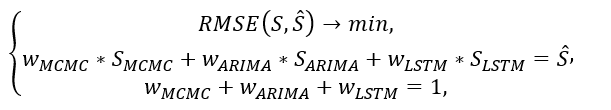

where *S* is the actual data for the prediction period;
*S^* - predicted data for the period;
*W* - weights for the forecasts of each model; 
The output is weighted prediction data which are close to the actual data. The model shown above is solved with PuLP package:

In [ ]:
"""
The code imports the pulp library and sets up variables for a portfolio optimization problem involving three prediction algorithms: LSTM, MCMC, and ARIMA.

The first few lines of code are similar to the previous code blocks and download historical stock prices for a given stock_name, removes unnecessary columns, and converts the 'Close' price data to a numpy array.

Predicted stock prices and mean squared errors will be stored in preds and mse variables, respectively.

Each algorithm's weights are stored in the variables weights_lstm, weight_mcmc, and weight_arima. In order to minimize the overall risk of the portfolio while achieving a target return, these weights are used to determine the optimal allocation of funds across the three algorithms.

A linear programming problem such as this optimization problem can be solved using the pulp library.
"""
import pulp as plp

hist_data = yf.download(stock_name, start="2021-04-01", end="2021-05-04")
hist_data = hist_data.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)
hist_data = hist_data['Close']
hist_data = np.array(hist_data)

preds = []
mse = []

weights_lstm = 0.3
weight_mcmc = 0.4
weight_arima = 0.4

"""
Using the pulp library, the code determines the optimal weights for three prediction algorithms (LSTM, MCMC, and ARIMA).

The plp.LpProblem() function is used to create a new optimization problem object called model. Using the weights assigned to each algorithm, the optimization problem seeks to minimize the mean squared error (MSE) between predicted and actual stock prices.

For each algorithm in the portfolio, three decision variables are defined using plp.LpVariable(). Lower and upper bounds for each weight variable are set using the lowBound and upBound parameters.

Based on the weights assigned to each algorithm, the following for loops calculate the predicted stock prices and the mean squared error. The predicted stock prices for each algorithm are calculated as a linear combination of the algorithm's predictions and its assigned weight.

MSE is set as the target function of the optimization problem. In order to ensure that the sum of the weights represents the total allocation of funds in the portfolio, two constraints are added.

The plp.LpSolverDefault.msg parameter is set to 1 to display the solver's output messages.
"""
# weights solver
model = plp.LpProblem('Optimal_weights', plp.LpMinimize)
# weights--->variables
weight_lstm = plp.LpVariable("weight_lstm", lowBound = 0, upBound=0.6)
weight_mcmc = plp.LpVariable("weight_mcmc", lowBound = 0, upBound=0.6)
weight_arima = plp.LpVariable("weight_arima", lowBound = 0, upBound=0.6)

for i in range(len(hist_data)):
    preds.append(lstm_pred[i]*weight_lstm + mcmc_pred[i]*weight_mcmc + arima_pred[i]*weight_arima)
    
for i in range (len(hist_data)):
    mse.append(hist_data[i] - preds[i])
# target function--->mean squared error
mse = np.mean(mse)
sum_w = weight_lstm + weight_mcmc + weight_arima 

model += mse
model += sum_w <= 1.0
model += sum_w >= 1.0

plp.LpSolverDefault.msg = 1

"""
Using the model.solve() function, the previous code block solves the optimization problem. The status of the optimization problem is printed to the console using the plp.LpStatus[] function.

In the next step, the optimized weights for each algorithm are extracted from the decision variables in the optimization problem using the .varValue attribute. We store these weights in the variables weight_lstm_f, weight_mcmc_f, and weight_arima_f.

Following the optimization of each algorithm's weights, the final predicted stock prices are calculated. Using the optimized weights of each algorithm, we calculate the predicted stock prices as a linear combination.

Finally, the predicted stock prices are stored in the preds_final variable and printed to the console. Based on these final predicted prices, the optimized portfolio can be evaluated against actual historical prices.
"""
# solve #
model.solve()
print('model solve')
status = model.solve()
print("Model status: ", plp.LpStatus[status])
print(model)

weight_mcmc_f = weight_mcmc.varValue
weight_arima_f = weight_arima.varValue
weight_lstm_f = weight_lstm.varValue

preds_final = []
# Create final predictions from 3 methods
for i in range(len(hist_data)):
    preds_final.append(lstm_pred[i]*weight_lstm_f + mcmc_pred[i]*weight_mcmc_f + arima_pred[i]*weight_arima_f)
preds_final = np.vstack(preds_final)    
#print(preds_final)

"""
By comparing the final predicted stock prices generated by the optimized portfolio with the actual historical prices, the code generates a graph.

Preds_final is converted into a one-dimensional array of 22 elements using the np.reshape() function. Using the go.Figure() function, a new figure is created and two traces are added: one for the actual historical prices and one for the final predicted prices.

You can modify the title, axis labels, and legend position of the graph using the fig.update_layout() function. This graph compares historical and predicted prices over time, allowing for a visual comparison.

Fig.show() displays the graph on the screen. To determine if the optimized portfolio performs better than any individual algorithm, it is possible to assess the accuracy of the optimized portfolio in predicting future stock prices.
"""
# build graphs
preds_gr = np.reshape(preds_final, (22,))
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(0, 21)), y=hist_data, mode='lines+markers',  name='historical', marker_color='#39304A'))
fig.add_trace(go.Scatter(x=list(range(0, 21)), y=preds_gr, mode='lines+markers', name='predictions', marker_color='#FFAA00'))
fig.update_layout(legend_orientation="h",
                legend=dict(x=.5, xanchor="center"),
                plot_bgcolor='#FFFFFF',  
                xaxis=dict(gridcolor = 'lightgrey'),
                yaxis=dict(gridcolor = 'lightgrey'), 
                title_text = f'{stock_name} final prediction', title_x = 0.5,
                xaxis_title="Timestep",
                yaxis_title="Stock price",
                margin=dict(l=0, r=0, t=30, b=0))
fig.show()

"""
In addition to the weights assigned to each algorithm in the portfolio, the code calculates the root mean square error (RMSE) of the optimized portfolio's predictions.

The mean squared error (MSE) between the actual historical prices and the final predicted prices for the optimized portfolio is first stored in an empty list called mse. The absolute difference between each historical price and its predicted price is then calculated using a for loop. The mse list stores these absolute differences.

The mean squared error of the optimized portfolio's predictions is calculated using the mse list. RMSE is calculated by taking the square root of the MSE using the math.sqrt() function.

The RMSE and the weights assigned to each algorithm in the portfolio are then printed to the console. By comparing these values to the performance of the individual algorithms in the portfolio, we can assess the accuracy of the optimized portfolio.
"""
mse = []
for i in range (len(hist_data)):
    mse.append(abs(hist_data[i] - preds_final[i]))
mse = np.mean(mse)
rmse = math.sqrt(mse)
print(f'RMSE = {rmse}')
print(f'LSTM weight: {weight_lstm_f}')
print(f'MCMC weight: {weight_mcmc_f}')
print(f'ARIMA weight: {weight_arima_f}')

Calculated weights speak for themselves. Sadly, ARIMA did not prove to be efficient at all.

<a id="section-seven"></a>
# Summary

On historical stock data, various methods of stock price prediction were tested. The advantages and disadvantages of each method can be used for good by blending them together to generate one prediction. We have high volatility in last year's historical data, so methods like ARIMA aren't effective in forecasting. As a result of our blending method, we are able to make flexible predictions, based on previous historical data.

***If you made it this far, congrats! Thank you for reading this and hope you enjoyed my notebook! Please feel free to comment and upvote :)***